<a href="https://colab.research.google.com/github/garrettfarley9/Machine-Learning-Final-Project--Farley-Garrett-/blob/main/Farley_ML_Project_part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from yellowbrick.regressor import ResidualsPlot
from google.colab import files
files.upload()

Saving SeoulBikeData.csv to SeoulBikeData.csv


{'SeoulBikeData.csv': b'Date,Rented Bike Count,Hour,Temperature(\xb0C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(\xb0C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day\r\n01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0,0,0,Winter,No Holiday,Yes\r\n01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0,0,0,Winter,No Holiday,Yes\r\n01/12/2017,173,2,-6,39,1,2000,-17.7,0,0,0,Winter,No Holiday,Yes\r\n01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0,0,0,Winter,No Holiday,Yes\r\n01/12/2017,78,4,-6,36,2.3,2000,-18.6,0,0,0,Winter,No Holiday,Yes\r\n01/12/2017,100,5,-6.4,37,1.5,2000,-18.7,0,0,0,Winter,No Holiday,Yes\r\n01/12/2017,181,6,-6.6,35,1.3,2000,-19.5,0,0,0,Winter,No Holiday,Yes\r\n01/12/2017,460,7,-7.4,38,0.9,2000,-19.3,0,0,0,Winter,No Holiday,Yes\r\n01/12/2017,930,8,-7.6,37,1.1,2000,-19.8,0.01,0,0,Winter,No Holiday,Yes\r\n01/12/2017,490,9,-6.5,27,0.5,1928,-22.4,0.23,0,0,Winter,No Holiday,Yes\r\n01/12/2017,339,10,-3.5,24,1.2,1996,-21.2,0.65,0,0,Winter,No

#Data

In [12]:
bdf = pd.read_csv('SeoulBikeData.csv', encoding = 'unicode_escape')
bdf.describe()

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
std,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000


In [13]:
'''
ToDo: Add column with name of days
ToDo: Convert 'Date' column to parsable format for StandardScaler

#bdf['Date'] = bdf['Date'].apply(lambda x : datetime.strptime(x, '%d/%m/%Y'))
#bdf['Day of Week'] = bdf['Date'].apply(lambda x: pd.Series.dt.day_name(x))
'''
bdf['Hour avg'] = bdf.groupby(['Hour'])['Rented Bike Count'].transform('mean')
bdf['Season avg'] = bdf.groupby(['Seasons'])['Rented Bike Count'].transform('mean')



#plot = sns.barplot(data = bdf, x = 'Seasons', y = 'Season avg')
#plot = sns.boxplot(data = bdf, x = 'Holiday', y = 'Rented Bike Count')
#plot = sns.boxplot(data = bdf, x = 'Seasons', y = 'Rented Bike Count')
#plot = sns.lineplot(data = bdf, x = 'Hour', y = 'Rented Bike Count')
#plot = sns.lineplot(data = bdf, x= 'Temperature(°C)', y = 'Rented Bike Count')
#plot = sns.scatterplot(data = bdf, x= 'Rainfall(mm)', y = 'Rented Bike Count')

#Plots

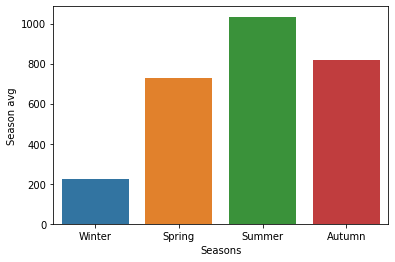

In [ ]:
plot = sns.barplot(data = bdf, x = 'Seasons', y = 'Season avg')

This plot shows aggregated seasonal average of bike rental volume by season.

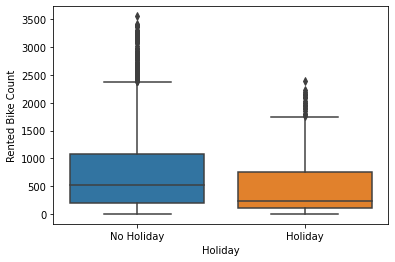

In [ ]:
plot = sns.boxplot(data = bdf, x = 'Holiday', y = 'Rented Bike Count')

This plot shows the number of rented bikes on Holiday vs No Holiday

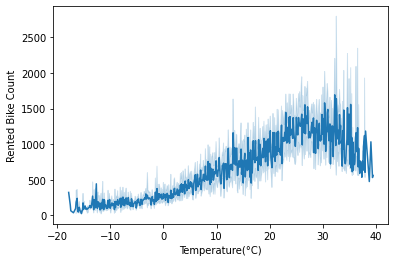

In [ ]:
plot = sns.lineplot(data = bdf, x= 'Temperature(°C)', y = 'Rented Bike Count')

This plot shows the rented bike count as a function of temperature.

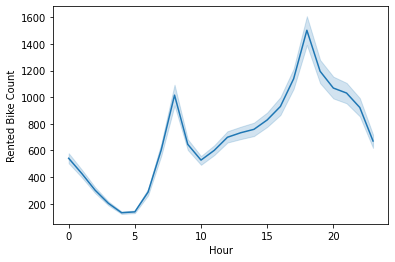

In [ ]:
plot = sns.lineplot(data = bdf, x = 'Hour', y = 'Rented Bike Count')

This plot shows the rented bike count as a function of time in the day.

#Analysis

There are some relationships between features and the rented bike count that I can use to predict the volume of bike rentals in a given hour. The time of day matters and we even see two spikes where people are going to work, and coming from work. We even see that in the plot of Holidays vs Non-Holidays where holidays don't see as many rentals. There is a seasonal relationship that is likely connected to the temperature more than anything. It seems that the temperature outside matters a lot when people consider a bike ride and the warmer it gets, the more variable the data gets. The other features were really noisy when compared to bike rental numbers or they were corelated to another variable, e.g. humidity and dew point with temperature.

##Preprocessing Data

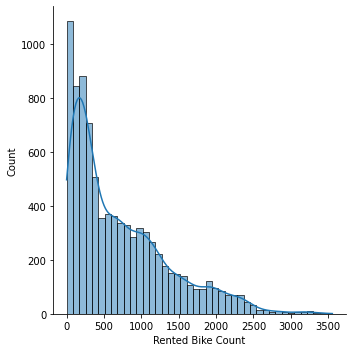

In [ ]:
plot = sns.displot(bdf, x = 'Rented Bike Count', kde = True)

###Imputation
There are no values that need to be imputed.

In [ ]:
bdf.isnull().sum()

Date                         0
Rented Bike Count            0
Hour                         0
Temperature(°C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(°C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
Hour avg                     0
Season avg                   0
dtype: int64

###Encoding features
Holiday were encoded with Label encoding and Seasons were OneHot encoded. Other binary encoding of atmospheric data split on the mean will hopefully improve the model's fit.

In [14]:


le = LabelEncoder()
bdf['Holiday'] = le.fit_transform(bdf['Holiday'])
bdf['Functioning Day'] = le.fit_transform(bdf['Holiday'])

temp = pd.get_dummies(bdf, columns = ['Seasons'])
temp = temp.filter(regex = 'Seasons_\w+')
bdf = pd.concat([bdf, temp], axis = 1)
bdf = bdf.drop(columns = ['Seasons'])

bdf['Visibility_bin']=bdf['Visibility (10m)'].apply(lambda x: 1 if x>=2000 else 0)
bdf['Rainfall_bin']=bdf['Rainfall(mm)'].apply(lambda x:1 if x>=0.148687 else 0)
bdf['Snowfall_bin']=bdf['Snowfall (cm)'].apply(lambda x:1 if x>=0.075068 else 0)
bdf['Solar Radiation_bin']=bdf['Solar Radiation (MJ/m2)'].apply(lambda x:1 if x>=0.56911 else 0)



##Fitting the Models

###Assign data and fit models
Data was assigned to test or train data then passed through the linear regression model and the stochastic gradient descent regression model.


In [15]:

y_data = bdf['Rented Bike Count']
x_data = bdf.drop(columns = ['Rented Bike Count', 'Date'])

#Scale data
scaler = StandardScaler()
x_data = scaler.fit_transform(x_data)

#Assign test and train data
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.10, random_state = 4200)

#Initialize regression model object
lin_reg = linear_model.LinearRegression()
sgd_reg = linear_model.SGDRegressor()

#Train models
lin_reg = lin_reg.fit(x_train, y_train)
sgd_reg = sgd_reg.fit(x_train, y_train)




###Accuracy and residual plots
The accuracy and plots of residuals.

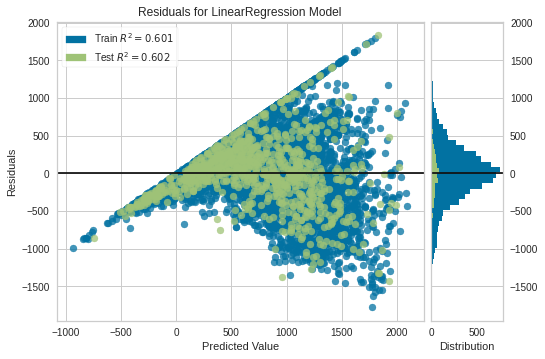

In [16]:
#Check accuracy of linear regression model
lin_reg.predict(x_test)
lin_reg.score(x_test, y_test)

viz = ResidualsPlot(lin_reg)
viz.fit(x_train,y_train)
viz.score(x_test, y_test)
viz.show()

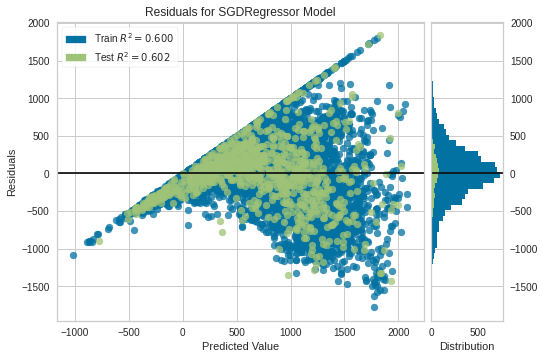

In [17]:
#Check accuracy of SGD regression model
sgd_reg.predict(x_test)
sgd_reg.score(x_test, y_test)

viz = ResidualsPlot(sgd_reg)
viz.fit(x_train,y_train)
viz.score(x_test, y_test)
viz.show()

###Fitting models with less training data

In [ ]:
p = [0.2, 0.3, 0.5, 0.7, 0.8, 0.9]

for i in p:
  x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = i, random_state = 4200)
  lin_reg = linear_model.LinearRegression()
  lin_reg = lin_reg.fit(x_train, y_train)

  viz = ResidualsPlot(lin_reg)
  viz.fit(x_train,y_train)
  viz.score(x_test, y_test)
  viz.show()
  

